# Informatyka w medycynie: Projekt II
## Wykrywanie naczyń dna siatkówki oka

### Biblioteki 

In [11]:
from skimage import io, exposure, morphology, filters, measure
from sklearn import metrics, ensemble, model_selection
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Ustawienia dotyczące danych

In [12]:
#LICZBA PRÓBEK TRENINGOWYCH
TRAIN_SAMPLES = 1000000

#CZY POKAZAĆ WYKRESY?
SHOW_PLOTS = True

#NUMER SPRAWDZANEGO OBRAZKA
SELECT_IMAGE_NUM = 1 

### Inicjalizacja danych

In [13]:
#POBRANIE DANYCH DO TABLIC PLIKÓW WEJŚCIOWYCH/WYJŚCIOWYCH
DATA_INPUT = ["Desktop/Data/Images/" + str(x // 10) + str(x % 10) + "_h.jpg" for x in range(1, 16)]
DATA_OUTPUT = ["Desktop/Data/Output/" + str(x // 10) + str(x % 10) + "_h.tif" for x in range(1, 16)]

#WYBRANY PLIK POCZĄTKOWY ORYGINAŁ(INPUT)/MASKA EKSPERCKA
img = io.imread(DATA_INPUT[SELECT_IMAGE_NUM])
output = io.imread(DATA_OUTPUT[SELECT_IMAGE_NUM]) // 255

### Implementacja funkcji przetwarzania obrazu

In [14]:
def imageProcessing(img):
    #WSTĘPNE PRZETWRZANIE OBRAZU
    
    print("WSTĘPNE PRZETWARZANIE OBRAZU")

    #EKSTRAKCJA KANAŁU ZIELENI
    img_g = img[:, :, 1]

    # USTAWIENIE WARTOŚCI CZERNI NA 0
    mask = img[:, :, 0] > 10
    img_g = img_g * mask

    #UTWORZENIE MASKI BINARNEJ DLA OKA (POZBYCIE SIĘ TŁA)
    mask = morphology.binary_erosion(mask * 1, footprint=np.ones((15, 15)))
    mask[:20, :] = 0
    mask[-20:, :] = 0

    #ZASTOSOWANIE METODY: CONTRAST STRETCHING
    p1, p99 = np.percentile(img_g[np.nonzero(img_g)], (1, 99))
    img_rescale = exposure.rescale_intensity(img_g, in_range=(p1, p99))

    #ZASTOSOWNAIE: ADAPTIVE EQUALIZATION, VALUE = 0.07
    img_adapteq = exposure.equalize_adapthist(img_rescale, clip_limit=0.07)
    
    #PREZENTACJA WSTĘPNEGO PRZETWARZANIA OBRAZU
    if SHOW_PLOTS:
        plt.figure()
        plt.title("WSTĘPNE PRZETWARZANIE OBRAZU")
        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("ORYGINAŁ")
        plt.subplot(2, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title("MASKA")
        plt.subplot(2, 2, 3)
        plt.imshow(img_rescale, cmap='gray')
        plt.axis('off')
        plt.title("CONTRAST STRETCHING")
        plt.subplot(2, 2, 4)
        plt.imshow(img_adapteq, cmap='gray')
        plt.axis('off')
        plt.title("ADAPTIVE EQUALIZATION 0.07")
        plt.show()

    return img_adapteq, mask


In [15]:
def vesselsExtraction(img):
    # WŁAŚCIWE PRZETWARZANIE OBRAZU
    print("WŁAŚCIWE PRZETWARZANIE OBRAZU")

    # ZASTOSOWANIE FILTRA FRANGI
    frangi = filters.frangi(img)

    # DYLATACJA: MORPHOLOGY CLOSING
    closing = morphology.closing(frangi)

    # HISTOGRAM: EQUALIZE
    eq_hist = exposure.equalize_hist(closing)

    # ZASTOSOWANIE EROZJI 
    erosion = morphology.erosion(morphology.erosion(morphology.erosion(eq_hist)))

    # PREZENTACJA WŁAŚCIWEGO PRZETWARZANIA OBRAZU
    if SHOW_PLOTS:
        plt.figure()
        
        plt.subplot(2, 2, 1)
        plt.imshow(frangi, cmap='gray')
        plt.axis('off')
        plt.title("FILTR FRANGI")
        
        plt.subplot(2, 2, 2)
        plt.imshow(closing, cmap='gray')
        plt.axis('off')
        plt.title("DYLATACJA")
        
        plt.subplot(2, 2, 3)
        plt.imshow(eq_hist, cmap='gray')
        plt.axis('off')
        plt.title("HISTOGRAM: EQUALIZED")
        
        plt.subplot(2, 2, 4)
        plt.imshow(erosion, cmap='gray')
        plt.axis('off')
        plt.title("EROZJA")
        
        plt.show()

    return erosion

In [16]:
def binaryMask(img, mask):
    # KOŃCOWE PRZETWARZANIE OBRAZU
    print("KOŃCOWE PRZETWARZANIE OBRAZU")

    # THRESHOLD
    threshold = (img > 0.85) * 1

    # ZASTOSOWANIE BINARNEJ MASKI Z PREPROCESINGU
    masked = threshold * mask

    # BINARNA DYLATACJA NA UTWORZONEJ MASCE
    binary_output = morphology.binary_dilation(masked)
    
    # PREZENTACJA KOŃCOWEGO PRZETWARZANIA OBRAZU
    if SHOW_PLOTS:
        plt.figure(figsize=(6, 9))
        plt.subplot(2, 2, 1)
        plt.imshow(threshold, cmap='gray')
        plt.axis('off')
        plt.title("BINARNY THRESHOLD")
        plt.subplot(2, 2, 2)
        plt.imshow(masked, cmap='gray')
        plt.axis('off')
        plt.title("MASKOWANIE")
        plt.subplot(2, 1, 2)
        plt.imshow(binary_output, cmap='gray')
        plt.axis('off')
        plt.title("KOŃCOWY WYNIK")
        plt.show()

    return binary_output

### Implementacja analizy statycznej jakości algorytmów

In [17]:
def show_confusion_matrix(real_matrix, predicted_matrix):
    print("ANALIZA STATYSTYCZNA JAKOŚCI ALGORYTMU\n")

    #WYKORZYSTNAIE CONFUSION_MATRIX DO WYLICZENIA PARAMETRÓW OCENY ANALIZY STATYSTYCZNEJ 
    tn, fp, fn, tp = metrics.confusion_matrix(real_matrix, predicted_matrix).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)
    
    g_mean1 = (precision * sensitivity) ** (1 / 2)
    g_mean2 = (sensitivity * specificity) ** (1 / 2)

    # PREZENTACJA WYNIKÓW

    print("Confusion Matrix:")
    print("True Positive:", tp)
    print("False Positive:", fp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("F1-score:", f1_score)
    
    print("\nG-mean = sqrt(precision * sensitivity):", g_mean1)
    print("G-mean = sqrt(sensitivity * specificity):", g_mean2)




## Wymagania obowiązkowe: Metoda przetwarzania obrazu

METODA: IMAGE PROCESSING

WSTĘPNE PRZETWARZANIE OBRAZU


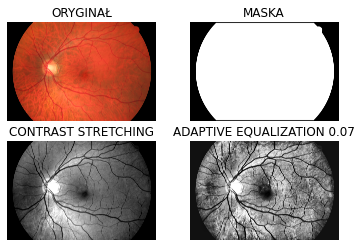

WŁAŚCIWE PRZETWARZANIE OBRAZU


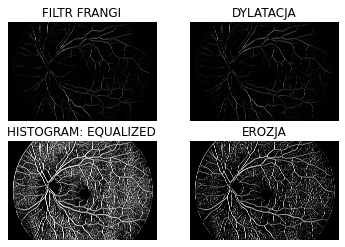

KOŃCOWE PRZETWARZANIE OBRAZU


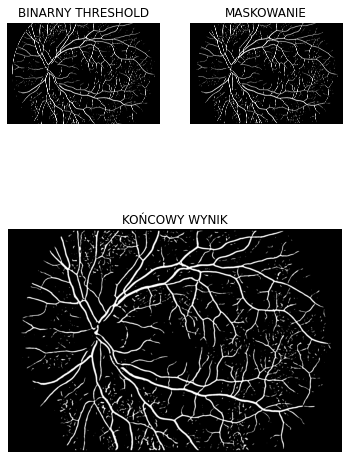

ANALIZA STATYSTYCZNA JAKOŚCI ALGORYTMU

Confusion Matrix:
True Positive: 598747
False Positive: 193385
False Negative: 209691
True Negative: 7183521

Accuracy: 0.950756376274473
Precision: 0.7558677089172007
Sensitivity: 0.7406220390431919
Specificity: 0.9737850800864211
F1-score: 0.7481672154295033

G-mean = sqrt(precision * sensitivity): 0.748206043697298
G-mean = sqrt(sensitivity * specificity): 0.8492388895967041


In [18]:
# IMAGE PROCESSING
print("METODA: IMAGE PROCESSING\n")

# WSTĘPNE PRZETWARZANIE OBRAZU
preprocessed_img, mask = imageProcessing(img)

# WŁAŚCIWE PRZETWARZANIE OBRAZU
extracted_vessels = vesselsExtraction(preprocessed_img)

# KOŃCOWE PRZETWARZANIE OBRAZU
binary_output = binaryMask(extracted_vessels, mask)


# WYŚWIETLENIE WYNIKÓW OCENY ANALIZY STATYSTYCZNEJ ALGORYTMU
show_confusion_matrix(output.ravel(), binary_output.ravel())


# Wymagania na 4.0

## Implementacja ekstakcji cech z obrazu 5x5

In [19]:
#FUNKCJA DO EKSTRAKCJI CECH Z SĄSIEDZTWA DANEGO PIKSELU OBRAZU (5X5)
def getData(x, y, img):

    # PODZIAŁ DANEGO OBRAZU NA WYCINKI
    data = []
    new_image = img[x - 2:x + 2, y - 2:y + 2]

    # ZAPIS LOKACJI PIXELA DO LISTY
    data.append(x)
    data.append(y)

    # ZAPIS WARTOŚCI PIKSELI DO ZBIORU DANYCH 
    for pixel_val in new_image.ravel():
        data.append(pixel_val)

    # ZAPISANIE CENTRALNYCH MOMENTÓW DO ZBIORU DANYCH
    central_moments = measure.moments_central(new_image)
    for central_moment in central_moments.ravel():
        data.append(central_moment)

    # ZAPISANIE MOMENTÓW HU DO ZBIORU DANYCH
    hu_moments = measure.moments_hu(measure.moments_normalized(central_moments))
    for hu_moment in hu_moments:
        data.append(hu_moment)

    # ZAPISANIE WARIACJI PIKSELI DO ZBIORU DANYCH
    variation = np.var(new_image)
    data.append(variation)

    return data


# Metoda Machine Learning: Klasyfikator Las Losowy

METODA: MACHINE LEARNING: LAS LOSOWY
ZBIERANIE DANYCH TRENINGOWYCH... ( 1 / 4 )
WSTĘPNE PRZETWARZANIE OBRAZU
ZBIERANIE DANYCH TRENINGOWYCH... ( 2 / 4 )
WSTĘPNE PRZETWARZANIE OBRAZU
ZBIERANIE DANYCH TRENINGOWYCH... ( 3 / 4 )
WSTĘPNE PRZETWARZANIE OBRAZU
ZBIERANIE DANYCH TRENINGOWYCH... ( 4 / 4 )
WSTĘPNE PRZETWARZANIE OBRAZU
TRENING...
KLASYFIKOWANIE...
ANALIZA STATYSTYCZNA JAKOŚCI ALGORYTMU

Confusion Matrix:
True Positive: 60806
False Positive: 419630
False Negative: 747632
True Negative: 6957276

Accuracy: 0.857396097219616
Precision: 0.12656420418120207
Sensitivity: 0.07521417845276941
Specificity: 0.9431157181615165
F1-score: 0.09435522789659812

G-mean = sqrt(precision * sensitivity): 0.09756752860976688
G-mean = sqrt(sensitivity * specificity): 0.2663375188129004


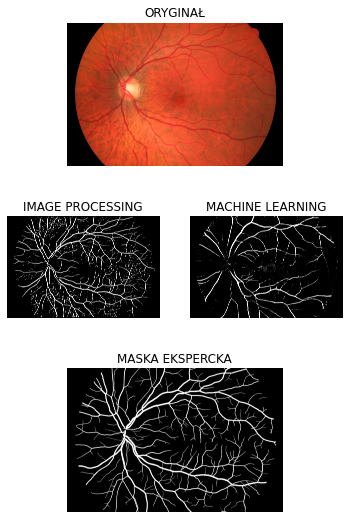

In [21]:
    # MACHINE LEARNING: LAS LOSOWY
    
    print("METODA: MACHINE LEARNING: LAS LOSOWY")
    SHOW_PLOTS = False

    # SELEKCJA OBRAZÓW DO NAUKI
    learning_image_set = [10, 11, 12, 13]
    samples_per_image = TRAIN_SAMPLES // len(learning_image_set)

    # INICJALIZACJA: TRAINING DATASETS
    train_set = []
    train_classes = []

    # ZEBRANIE: DATASETÓW TRENINGOWYCH
    counter = 0
    for i in learning_image_set:

        counter += 1
        print("ZBIERANIE DANYCH TRENINGOWYCH... (", counter, '/', len(learning_image_set), ')')

        training_img = io.imread(DATA_INPUT[i])
        training_output = io.imread(DATA_OUTPUT[i]) // 255
        preprocessed_img, _ = imageProcessing(training_img)        

        # WYBIERANIE: RANDOM PIKSEL Z DANEGO OBRAZU
        train_samples_x = np.random.randint(2, preprocessed_img.shape[0] - 4, samples_per_image)
        train_samples_y = np.random.randint(2, preprocessed_img.shape[1] - 4, samples_per_image)

        # UTWORZENIE TRAIN DATASET
        for j in range(samples_per_image):
            train_set.append(getData(train_samples_x[j], train_samples_y[j], preprocessed_img))
            train_classes.append(training_output[train_samples_x[j], train_samples_y[j]])

    # UTWORZENIE: RANDOM FOREST CLASSIFIER
    clf_forest = ensemble.RandomForestClassifier(n_jobs=-1)

    # TRENING
    print("TRENING...")
    clf_forest.fit(train_set, train_classes)

    # INICJALIZACJA ZAPISU WYNIKÓW
    ml_output = np.zeros(preprocessed_img.shape)
    test_set = []
    
     # KLASYFIKOWANIE
    print("KLASYFIKOWANIE...")
    for x in range(2, preprocessed_img.shape[0] - 2):
        test_set.clear()
        for y in range(2, preprocessed_img.shape[1] - 2):
            test_set.append(getData(x, y, preprocessed_img))
        predicted_forest = clf_forest.predict(test_set)
        ml_output[x, 2:-2] = predicted_forest.ravel()
        

    # PREZENTACJA JAKOŚCI ROZWIĄZANIA 
    show_confusion_matrix(output.ravel(), ml_output.ravel())

    # PREZENTACJA ORYGINALNEGO OBRAZKA
    plt.figure(figsize=(6, 9))
    plt.subplot(3, 1, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("ORYGINAŁ")

    # PREZENTACJA: WYNIK METODY IMAGE PROCESSING
    plt.subplot(3, 2, 3)
    plt.imshow(binary_output, cmap='gray')
    plt.axis('off')
    plt.title("IMAGE PROCESSING")

    # PREZENTACJA: WYNIK METODY MACHINGE LEARNING
    plt.subplot(3, 2, 4)
    plt.imshow(ml_output, cmap='gray')
    plt.axis('off')
    plt.title("MACHINE LEARNING")

    # MASKA EKSPERCKA 
    plt.subplot(3, 1, 3)
    plt.imshow(output, cmap='gray')
    plt.axis('off')
    plt.title("MASKA EKSPERCKA")
    plt.show()
